last edited by Claire Valva on September 10, 2018
# Spectral analysis performed on 40.5N data
end of notebook shows average fft magnitude vs. omega

In [1]:
#set whether or not to reload data, set to true/false
#or use data saved from an old session
do_trends = False
run_fresh = False

In [2]:
#import packages
import numpy as np
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib.cm as cm
from math import pi
import matplotlib.ticker as tck
import datetime
from sympy import solve, Poly, Eq, Function, exp, re, im
from PyEMD import EMD
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
import statsmodels.api as sm

In [3]:
#import own functions from functions_forspectralanalysis.py
#functions are based off of those in spectral_analysis_tests.ipynb 
#but edited so that they can be used in multiple notebooks
from functions_forspectralanalysis import *

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:75: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


## Import and edit file

In [4]:
#import file
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [5]:
#set indicies/number of things
number_entries = int(fileobj.dimensions['time'].size)
number_days = int(number_entries / 4)
number_lon = fileobj.dimensions['longitude'].size
year_number = 2016 - 1979 + 1

year_list = [1979 + i for i in range(2016-1979)]

In [6]:
#load coordinates
#so height[i] is the geopotential height at a given time
height = fileobj.variables['z'][:]
g_inv = 1/9.81
height = height*g_inv

In [7]:
#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')

#create longitude array
lon_increment = 1.5 # The increment of each longitude grid is 1.5
lon_list = [i * lon_increment for i in range(240)]

In [8]:
if run_fresh:

#get lists and then merge together as a dataframe
    lon_list = [lon_list[k]
               for i in range(number_entries)
               for k in range(number_lon)]

    z_temp = [height[i][k]
              for i in range(number_entries)
              for k in range(number_lon)]

    date_list = [tarray[i]
               for i in range(number_entries)
               for k in range(number_lon)]
    
    #make this a dataframe
    d = {'datetime' : date_list, 'lon': lon_list,
                    'z' : z_temp}
    geopot_df = pd.DataFrame(d)
    
    #get day/month/year separately for groupby
    geopot_df['month'] = geopot_df['datetime'].apply(lambda x: x.month)
    geopot_df['day'] = geopot_df['datetime'].apply(lambda x: x.day)
    geopot_df['year'] = geopot_df['datetime'].apply(lambda x: x.year)
    
    #sort into seasons    
    geopot_df["season"] = geopot_df["month"].apply(lambda x: season_sort(x))
    
    
    # Create storage object with filename `processed_data`
    data_store = pd.HDFStore('processed_data.h5')

    # Put DataFrame into the object setting the key as 'preprocessed_df'
    data_store['preprocessed_geopot'] = geopot_df
    data_store.close()
    
else:
        # Access data store
    data_store = pd.HDFStore('processed_data.h5')

    # Retrieve data using key
    geopot_df = data_store['preprocessed_geopot']
    data_store.close()

## Perform zonal fft

In [9]:
#get fft results at each date over entire longitude
fft_zonal_result = [geopot_fft(height[k]) 
                    for k in range(number_entries)]

## Perform time fft

### detrending

detrend all data using results from zonal fft

In [10]:
#get list of years and seasons to perform transform/detrend on
years = range(1979,2017)
seasons = ["winter", "spring", "summer", "fall"]

#### define some functions which depend on the files imported earlier

In [11]:
def trendsfordf(year, season):
    frame = geopot_df.query(query_string(year, season, 9))
    
    trend_list = [pairwavenum(k, frame, tarray, fft_zonal_result) 
                  for k in range(len(zonal_spacing))]
    
    return(trend_list)

##### TO DO: this function gets a lot of runtime warnings, likely from the fsolve - would be nice to fix it up later on // for time being just come back and give an option to pickle it later

##### TO DO: should be right, but check on the time indexing after finish  transforming back

In [12]:
def coeff_subtract(time, frame, tarray, fft_zonal_result, trend_list):
    #since gettimes depends on frame, get frame first
    
    #get first and last timestamp
    tmin, tmax = gettimes(frame, tarray)
 
    #get the time steps at the beginning and end of the seasons
    iter_list = time - tmin
    
    #get the results and then subtract the list
    results = fft_zonal_result[time]
    tosub = [sublist[1][iter_list - 1] for sublist in trend_list]
    
    results = results - tosub
    
    return results

In [13]:
def trendsfordf(year, season):
    frame = geopot_df.query(query_string(year, season, 9))
    
    #get trends
    trend_list = [pairwavenum(k, frame, tarray, fft_zonal_result) 
                  for k in range(len(zonal_spacing))]
    
    tmin, tmax = gettimes(frame, tarray)
    
    #adjust the list
    adjusted_list = [coeff_subtract(time, frame, tarray, fft_zonal_result, trend_list) for time in range(tmin, tmax+tmin)]
    
    #perform ifft on the list
    adjusted_list_ifft = [ifft(sublist) for sublist in adjusted_list]
    
    return(season, year, trend_list, adjusted_list, adjusted_list_ifft)

In [14]:
#get the trends in fourier coefficients
if do_trends == True:
    trends_all_list = [trendsfordf(time, season) for season in seasons
                       for time in years]
    
    import pickle

    file_Name = "test_trends_pickle"
    file_pickle = open(file_Name,'wb') 

    pickle.dump(trends_all_list,file_pickle)
    file_pickle.close()

In [15]:
if do_trends == False:
    import pickle
    
    file_Name = "test_trends_pickle"
    
    file_pickle = open(file_Name, "rb")
    
    trends_all_list = pickle.load(file_pickle)

note that the structre of trends_all_list is:

trends = [time, season, trends, adjusted forier coeffs, ifft of adjusted forier coeffs] * 152

where time is a year
season is a season
trends for that time and season are 240 entries of changing trends

In [16]:
#pull everything out of the list
season_index = [sublist[0] for sublist in trends_all_list]
year_index = [sublist[1] for sublist in trends_all_list]
trend_index = [sublist[2] for sublist in trends_all_list]
adjcof_index = [sublist[3] for sublist in trends_all_list]
untrend_index = [sublist[4] for sublist in trends_all_list]

In [17]:
#flatten list of detrended z values
flatten_df_untrend = [item for sublist in untrend_index for item in sublist]
flatten_df_untrend = [item for sublist in flatten_df_untrend for item in sublist]

In [18]:
#get list of same length for df binding - season, year, lon lists
season_df_list = []
year_df_list = []
lon_df_list = []

for i in range(len(untrend_index)):
    for j in range(len(untrend_index[i])):
        for k in range(240):
            entry = season_index[i]
            yr = year_index[i]
            lon = lon_list[k]
            
            season_df_list.append(entry)
            year_df_list.append(yr)
            lon_df_list.append(lon)

In [19]:
d = {"season": season_df_list, "year": year_df_list,
     "lon": lon_df_list, "adj_z": flatten_df_untrend}

untrend_df = pd.DataFrame(d)

### check if the detrending provided results that look sensible

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

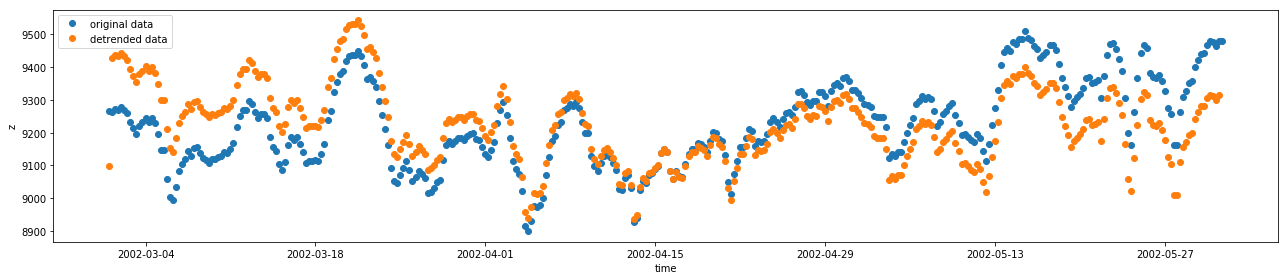

In [20]:
#slice some random part of original dataframe and detrended to see if have similar shape
year_test = 2002
season_test = "spring"

orig_data = geopot_df.query(query_string(year_test, season_test, 9))
untrend_data = untrend_df.query(query_string(year_test, season_test, 9))

#plot the results
#compare them again!
plt.clf();
plt.figure(figsize=(18,4))
plt.plot_date(orig_data["datetime"], orig_data["z"], label = "original data")
plt.plot_date(orig_data["datetime"][:367], untrend_data["adj_z"], label = "detrended data")
plt.xlabel('time')
plt.ylabel('z')
plt.legend()
plt.tight_layout()

the detrend is nice and neat (visually at least - so now perform the transform on the detrended data)

## Perform transform on the detrended data

window used in this case is hanning, where the window size is determined by the length of data but everything is zero padded to have the maximum length

In [21]:
#choose length of trend that is wanted
#made all the same for easier comparative purposes
want_size = 372

#window_length = 300 #may not be currently used

In [22]:
#get spacing
time_spacing_list = fftfreq(want_size, 0.25)
wavenum_time = 1/time_spacing_list
wavenum_time = 93 / wavenum_time

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
def time_spacing(numbers):
    #kept as reference until final is done
    num_entries = len(numbers)
    spacing = fftfreq(num_entries, 0.25)
    
    return(spacing)

In [24]:
def time_fft_window(numbers):
    num_entries = len(numbers)
    window = np.hanning(num_entries)
    fft_for = numbers*window
    fft_coeff = fft(fft_for, n = want_size)
    ck_coeff = fft_coeff/want_size
    
    return(ck_coeff)

In [25]:
def time_fft_nowindow(numbers):
    num_entries = len(numbers)
    fft_for = numbers
    fft_coeff = fft(fft_for, n = want_size)
    ck_coeff = fft_coeff/want_size
    
    return(ck_coeff)

In [26]:
#complete fft
grouped_untrend = untrend_df.groupby(["season","year","lon"])
grouped_z = grouped_untrend["adj_z"]
fft_grouped_wind = grouped_z.apply(time_fft_window)
fft_grouped_nowind = grouped_z.apply(time_fft_nowindow)

#get spacing of groups
#time_fft_spacing = grouped_z.apply(time_spacing) #left until sure that I will not use

/home/clairev/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [27]:
#get indexing of groups
names = grouped_untrend.apply(lambda x: x.name)

In [28]:
def get_ind(match, sublist):
    #function gets indices of the sublist that equal the match term
    toreturn = [j for j in range(len(sublist)) if sublist[j] == match]
    return toreturn

In [29]:
#get list of year/seasons/longitudes
time_fft_seasons = [sublist[0] for sublist in names]
time_fft_year = [sublist[1] for sublist in names]
time_fft_lon = [sublist[2] for sublist in names]

#get lists of indicies
lon_index_time = [get_ind(k, time_fft_lon) for k in lon_list]
season_index_time = [get_ind(match, time_fft_seasons) for match in seasons]
year_index_time = [get_ind(year, time_fft_year) for year in year_list]

In [30]:
def condition_func_wint(i):
    results = i in winter_indices 
    return(results)

In [31]:
#want to mean over time, also make sure not to use the first summer
winter_indices, spring_indices, summer_indices, fall_indices = season_index_time

#get matches for winter and longitude, where year != 1979
winter_lon_indices = [[i for i in lon_index_time[j] if condition_func_wint(i)] 
                      for j in range(len(lon_list))]

spring_lon_indices = [[i for i in lon_index_time[j] if i in spring_indices]
                     for j in range(len(lon_list))]

summer_lon_indices = [[i for i in lon_index_time[j] if i in summer_indices]
                     for j in range(len(lon_list))]

fall_lon_indices = [[i for i in lon_index_time[j] if i in fall_indices]
                     for j in range(len(lon_list))]

In [32]:
def get_avglist(indices, valuelist, ax = 0):
    #from indices and the value list, returns the list with the same indices
    toavg = [valuelist[i] for i in indices]
    averaged = np.average(toavg, axis = ax)
    return averaged

In [33]:
#now get the averages of each spectrum for the lists
winter_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in winter_lon_indices]
spring_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in spring_lon_indices]
fall_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in fall_lon_indices]
summer_ffts = [get_avglist(sublist,fft_grouped_wind) for sublist in summer_lon_indices]

# plot wavenumber vs. fourier coeff

As expected - the highest magnitude of fourier coefficents are in the lower numbers with a peak at about 90/the number of days in all seasons which likely represents daily patterns. The summer curve seems to be the smoothest. In all graphs there also appears to be a peak around f = 15

In [34]:
#flatten lists for plotting
flat_wint_ffts = [item for sublist in winter_ffts for item in sublist]
flat_spring_ffts = [item for sublist in spring_ffts for item in sublist]
flat_fall_ffts = [item for sublist in fall_ffts for item in sublist]
flat_summer_ffts = [item for sublist in summer_ffts for item in sublist]
flat_list_wtime = [wavenum_time for i in range(240)]
flat_list_wtime = [item for sublist in flat_list_wtime for item in sublist]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

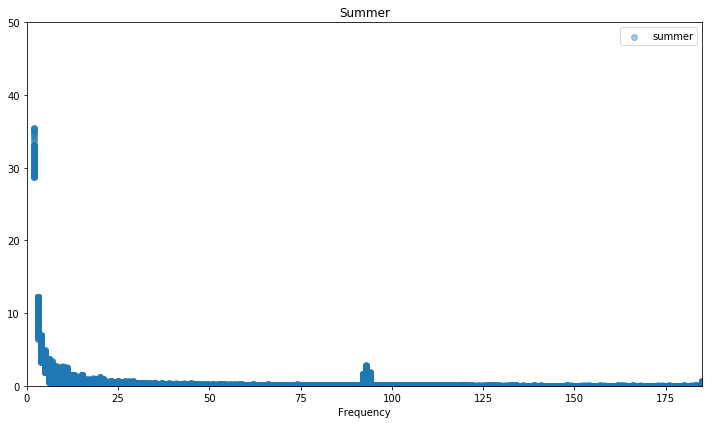

<Figure size 432x288 with 0 Axes>

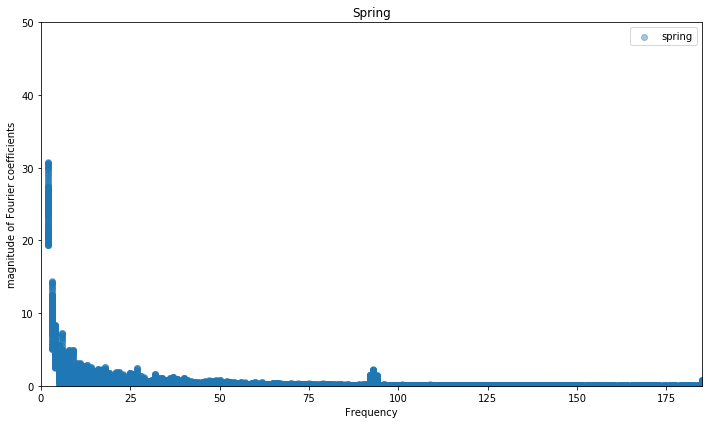

<Figure size 432x288 with 0 Axes>

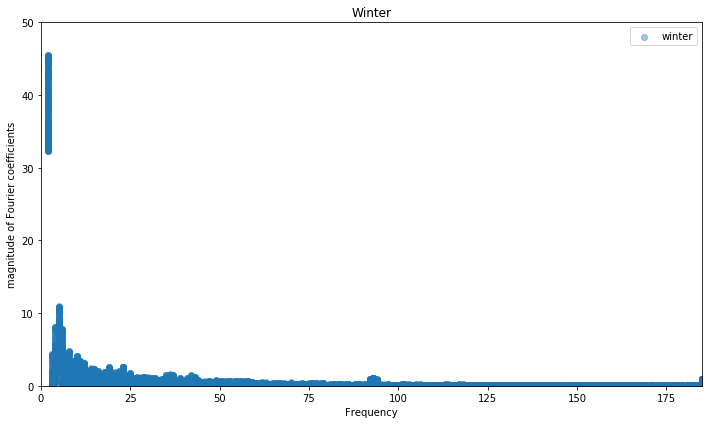

<Figure size 432x288 with 0 Axes>

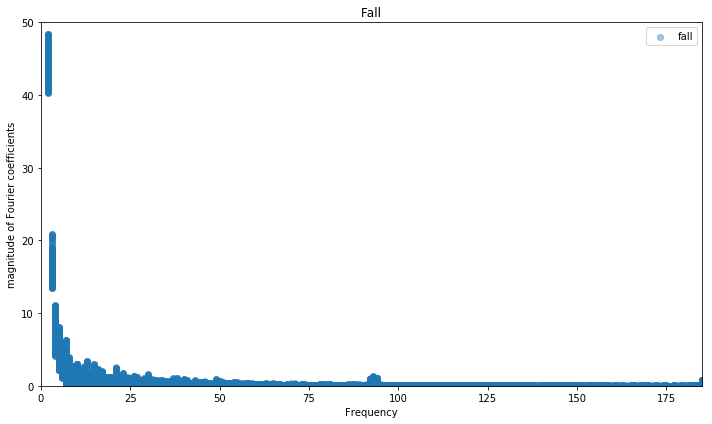

In [36]:
#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_summer_ffts, label = "summer", alpha = 0.4)
plt.title('Fourier spectrum')
plt.title('Summer')
plt.xlabel('Frequency');
plt.legend()
plt.ylim((0,50))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_spring_ffts, label = "spring", alpha = 0.4)
plt.title('Spring')
plt.xlabel('Frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.ylim((0,50))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_wint_ffts, label = "winter", alpha = 0.4)
plt.title('Winter')
plt.xlabel('Frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.ylim((0,50))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

#plot fourier coefficients vs. wavenumber
plt.clf();
plt.figure(figsize=(10,6))
plt.scatter(flat_list_wtime, flat_fall_ffts, label = "fall", alpha = 0.4)
plt.title('Fall')
plt.xlabel('Frequency');
plt.ylabel('magnitude of Fourier coefficients');
plt.legend()
plt.ylim((0,50))
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()

## Compare shapes of curves

In [37]:
#get loess fits for visualization purposes/comparative - NOT STAT
wint_lowess = sm.nonparametric.lowess(np.average(winter_ffts, axis = 0), wavenum_time, frac = 0.2)
lowess_x = list(zip(*wint_lowess))[0]
wint_lowess_y = list(zip(*wint_lowess))[1]

spring_lowess = sm.nonparametric.lowess(np.average(spring_ffts, axis = 0), wavenum_time, frac = 0.2)
spring_lowess_y = list(zip(*spring_lowess))[1]

summer_lowess = sm.nonparametric.lowess(np.average(summer_ffts, axis = 0), wavenum_time, frac = 0.2)
summer_lowess_y = list(zip(*summer_lowess))[1]

fall_lowess = sm.nonparametric.lowess(np.average(fall_ffts, axis = 0), wavenum_time, frac = 0.2)
fall_lowess_y = list(zip(*fall_lowess))[1]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

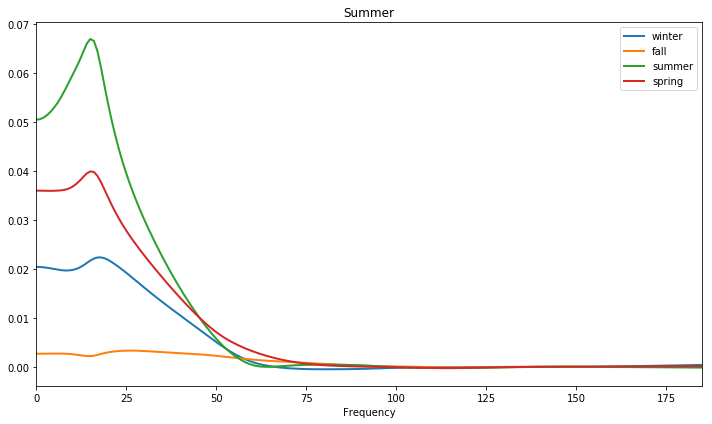

In [38]:
#plot loess
plt.clf();
plt.figure(figsize=(10,6))
plt.plot(lowess_x, wint_lowess_y, linestyle='-', linewidth=2, label = "winter")
plt.plot(lowess_x, fall_lowess_y, linestyle='-', linewidth=2, label = "fall")
plt.plot(lowess_x, summer_lowess_y, linestyle='-', linewidth=2, label = "summer")
plt.plot(lowess_x, spring_lowess_y, linestyle='-', linewidth=2, label = "spring")
plt.title('Fourier spectrum')
plt.title('Summer')
plt.xlabel('Frequency');
plt.legend()
plt.xlim((0,max(flat_list_wtime)))
plt.tight_layout()
plt.show()